# Packages needed

In [1]:
# import all packages
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from biosppy.signals.tools import filter_signal

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score

import biosppy as biosppy
import biosppy.signals.ecg as ecg
import pywt

import scipy as sp
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import interpolate
from pyentrp import entropy as ent
from scipy import stats
from statistics import pstdev,variance


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Data loading

In [2]:
df = pd.read_csv('X_train.csv', header=0)
x_train = df.copy()
data_raw = np.array(x_train) # a copy of the raw data

In [3]:
y_train = pd.read_csv('y_train.csv', index_col=['id'])
labels_raw = y_train.copy() # a copy of the raw labels
labels_sorted = y_train.copy().sort_values(by = ['y']) # a copy of the raw labels sorted
#labels_raw.head()

In [4]:
data = np.array(df)
l = np.array(y_train)
labels = [l[i][0] for i in range(len(l))]

# Data pre-processing

In [5]:
# remove nan values, compute and store general metrics: avg, ptp(range), autocorr,fft

autocorr = []
ptp = []
avg = []
fft=[]
n_train = len(data)
signal_raw = [] 
for x  in data:
    x = x[~np.isnan(x)]
    signal_raw.append(x)
    
    x_series = pd.Series(x)
    corr = x_series.autocorr(lag=2)
    autocorr.append(corr)

    avg.append(np.average(x))
    ptp.append(np.ptp(x))

    f = np.fft.fft(x)
    array = f[0:800]
    n = 15
    indices = array.argsort()[-n:][::-1]
    fft.append(indices)

signal_raw = np.asarray(signal_raw,dtype=object)
new_autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)

# ##################################################################
# # FIR filtering --- Info loss?

# signal_filtered = [] 
# for i in range(n_train):
#     signal_filtered.append(filter_signal(signal=signal_raw[i], ftype='FIR', band='bandpass',
#                                               order=int(0.3 * 300), frequency=(3,45),
#                                               sampling_rate=300))
# # trim params and convert to np.array
# sig_filtered = np.asarray([signal_filtered[i][0] for i in range(len(signal_filtered))],dtype=object)

In [6]:
#Padding the sequence with the values in last row to max length

sig_lengths = [len(signal_raw[i]) for i in range(len(signal_raw)) ]
to_pad = max(sig_lengths)

new_seq = []
for one_seq in signal_raw:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

signal_filtered = np.asarray(final_seq)

# Helper methods

In [7]:
    def extract_templates(signal):
        r_peaks = ecg.hamilton_segmenter(signal, 300)['rpeaks']
        beats = []
        rpeaks = []
        if len(r_peaks) >= 2:
            beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
            rpeaks = ecg.extract_heartbeats(signal, r_peaks, 300)['rpeaks']
        return beats,rpeaks
    
    

    def check_polarity(signal_raw, signal_filtered, temp):

        # Get extremes of median templates
        templates_min = np.min(np.median(temp, axis=0))
        templates_max = np.max(np.median(temp, axis=0))

        if np.abs(templates_min) > np.abs(templates_max):
            signal_raw *= -1
            signal_filtered *= -1
            temp *= -1
        return signal_raw, signal_filtered, temp

    

    def normalize_waveform_amplitude(normalize, signal_raw, signal_filtered, templates):
        """Normalize waveform amplitude by the median R-peak amplitude."""
        if normalize:

            # Get median templates max
            templates_max = np.max(np.median(templates, axis=0))
            for i in range(len(templates)): # added
                templates[i] /= templates_max
            return signal_raw / templates_max, signal_filtered / templates_max, templates
        else:
            return signal_raw, signal_filtered, templates

        
        
    def r_peak_check(rpeaks, template, median_template, sig, correlation_threshold=0.98):
        # Check lengths
        assert len(rpeaks) == len(template)
        #c = 0
        # Loop through rpeaks
        for template_id in range(len(template)):

            # Calculate correlation coefficient
            correlation_coefficient = np.corrcoef(
                median_template[template_rpeak_sp - 25:template_rpeak_sp + 25],
                template[template_id][template_rpeak_sp - 25:template_rpeak_sp + 25]
            )
            
            # Check correlation
            if correlation_coefficient[0][1] < correlation_threshold:
                # c += 1
                # Compute cross correlation
                cross_correlation = signal.correlate(
                    median_template[template_rpeak_sp - 25:template_rpeak_sp + 25],
                    template[template_id][template_rpeak_sp - 25:template_rpeak_sp + 25]
                )

                # Correct rpeak
                rpeak_corrected = rpeaks[template_id] - (25 - np.argmax(cross_correlation)) # ajust 

                # Check to see if shifting the R-Peak improved the correlation coefficient
                if check_improvement(rpeak_corrected, median_template, correlation_threshold, sig):
                    
                    # Update rpeaks array
                    rpeaks[template_id] = rpeak_corrected

        # Re-extract templates
        template, rpeaks = extract_templates_checked(rpeaks, sig)

        # Re-compute median template
        median_template = np.median(template, axis=0)

        # Check lengths
        assert len(rpeaks) == len(template)
        # if c > 0:
            # print(c)
        return rpeaks, template, median_template
    
    
    def check_improvement(rpeak_corrected, median_template, correlation_threshold, sig):

        # Before R-Peak
        a = rpeak_corrected - 60

        # After R-Peak
        b = rpeak_corrected + 120

        if a >= 0 and b < len(sig):

            # Update template
            template_corrected = sig[a:b]

            # Calculate correlation coefficient
            correlation_coefficient = np.corrcoef(
                median_template[60 - 25:60 + 25],
                template_corrected[60 - 25:60 + 25]
            )

            # Check new correlation
            if correlation_coefficient[0][1] >= correlation_threshold:
                return True
            else:
                return False
        else:
            return False
        
        
    def extract_templates_checked(rpeaks, sig):

        # Sort R-Peaks in ascending order
        rpeaks = np.sort(rpeaks)

        # Get number of sample points in waveform
        length = len(sig)

        # Create empty list for templates
        templates = []

        # Create empty list for new rpeaks that match templates dimension
        rpeaks_new = np.empty(0, dtype=int)

        # Loop through R-Peaks
        for rpeak in rpeaks:

            # Before R-Peak
            a = rpeak - 60
            if a < 0:
                continue

            # After R-Peak
            b = rpeak + 120
            if b > length:
                break

            # Append template list
            templates.append(sig[a:b])

            # Append new rpeaks list
            rpeaks_new = np.append(rpeaks_new, rpeak)

        # Convert list to numpy array
        templates = np.array(templates)

        return templates, rpeaks_new
    def safe_check(value):
        """Check for finite value and replace with np.nan if does not exist."""
        try:
            if np.isfinite(value):
                return value
            else:
                return np.nan
        except ValueError:
            return np.nan

In [8]:
# Extract elements of ecg signals using biosspy (FIR FILTERING INCLUDED)

# ts (array) – Signal time axis reference (seconds).
# filtered (array) – Filtered ECG signal.
# rpeaks (array) – R-peak location indices.
# templates_ts (array) – Templates time axis reference (seconds).
# templates (array) – Extracted heartbeat templates.
# heart_rate_ts (array) – Heart rate time axis reference (seconds).
# heart_rate (array) – Instantaneous heart rate (bpm).

ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(signal_filtered)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=signal_raw[i], sampling_rate=300.0, show=False)
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)
signal_filtered = np.asarray(filtered_list)

C:\Users\Yuda\AppData\Local\Temp\ipykernel_18184\675804099.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  signal_filtered = np.asarray(filtered_list)


In [9]:

# # Correct inverted signals
# for i in range(len(templates_list)):
#     _,_,templates_list[i] = check_polarity(signal_raw[i], signal_filtered[i], templates_list[i])

# Normalize the data and find the average characteristic heartbeat of each patient

# signal_normalized = normalize(signal_filtered)
templates_normalized=[]
patients_heartbeats=[]
patients_heartbeats_median=[]
for i in range(len(templates_list)):
    templates_normalized.append(normalize(templates_list[i]))
    patients_heartbeats.append(sum(templates_normalized[i])/len(templates_normalized[i]))
    patients_heartbeats_median.append(np.median(templates_normalized[i], axis=0))


In [10]:
# #r_peak check
# template_rpeak_sp = 60
# for i in range(len(rpeaks_list)):
#     rpeaks_list[i], templates_normalized[i], patients_heartbeats_median[i] = r_peak_check(rpeaks_list[i], templates_normalized[i], patients_heartbeats_median[i], signal_normalized[i])

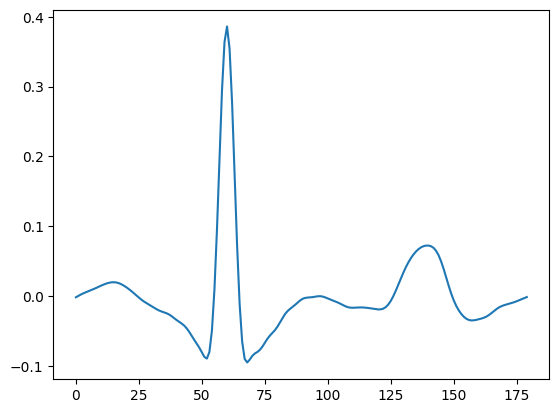

In [11]:
plt.plot(patients_heartbeats[1661])
plt.show()

In [12]:
labels_raw.iloc[1661]

y    0
Name: 1661, dtype: int64

15
52
60
68
140


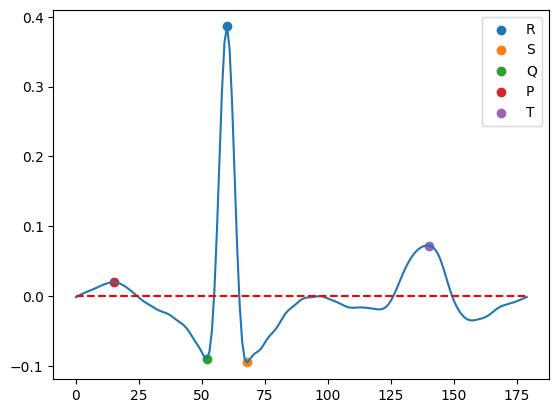

In [13]:
# Extarct the indices of PQRST peaks of a singal heartbeats / Visualization
patient_current = patients_heartbeats[1661]

# Find the R-peak
index = np.where(patient_current==max(patient_current))
R = index[0]
# First-half
first_half = patient_current[0:R[0]]
index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))

Q = index[0]
index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
P = index[0]


#Second half
second_half = patient_current[R[0]+1:] 
index = np.where(patient_current==min(second_half[0:30]))
S = index[0]

second_half = second_half[S[0]-R[0]+1:]
index = np.where(patient_current==max(second_half))
T = index[0] 


print(P[0])
print(Q[0])
print(R[0])
print(S[0])
print(T[0])

plt.plot(patient_current)
plt.scatter(R,patient_current[R],label='R')
plt.scatter(S,patient_current[S],label='S')
plt.scatter(Q,patient_current[Q],label='Q')
plt.scatter(P,patient_current[P],label='P')
plt.scatter(T,patient_current[T],label='T')
plt.plot(np.arange(0, 180),np.zeros(180), 'r--') 
plt.legend()
plt.show()

In [14]:
# Extarct all the peaks 
P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]

for i in range(len(patients_heartbeats)):
    # print(i)
    patient_current = patients_heartbeats[i]
    # Find the R-peak
    index = np.where(patient_current==max(patient_current))
    R = index[0]

    # First-half
    first_half = patient_current[0:R[0]]
    index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))

    Q = index[0]
    index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
    P = index[0]

    #Second half
    second_half = patient_current[R[0]+1:] 
    index = np.where(patient_current==min(second_half[0:30]))
    S = index[0]

    second_half = second_half[S[0]-R[0]+1:]
    index = np.where(patient_current==max(second_half))
    T = index[0]
    
    P_list.append(P[0])
    Q_list.append(Q[0])
    R_list.append(R[0])
    S_list.append(S[0])
    T_list.append(T[0])

# Feature extraction --- template features

In [15]:
# Intervals and Ratios of peaks
PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
    PR_list.append(R_list[i]-P_list[i])
    QRS_list.append(S_list[i]-Q_list[i])
    ST_list.append(T_list[i]-S_list[i])
    
PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
# Q_list = np.array(Q_list).reshape(-1,1) # done later
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)



# Range, Mean and Median of amplitudes
max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):
    
    patient_current = patients_heartbeats_median[i]
    
    max_A.append(max(patient_current))
    min_A.append(min(patient_current))
    mean_A.append(np.mean(patient_current))
    median_A.append(np.median(patient_current))
    
    

# Heart rates mean, median, variant and standard deviation
hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)



################################
# TO-DO: Heart rate variability
################################


# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)


# Timings of peaks mean, median, variant and standard deviation
ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)



# Peaks mean, median, variant, mode and standard deviation
peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

# added 10.01 a.m. 12/6
# Peaks detection rate
peaks_dr = []
for i in range(len(ts_list)):
#     rri = np.diff(rpeaks_list[i])
#     rri_avg = np.mean(rri)
    peaks_detected = len(rpeaks_list[i])/(len(ts_list[i])/270)
    if(peaks_detected > 1.2):
        # print("false number of peaks detected ")
        peaks_dr.append(1.2)
    else:
        peaks_dr.append(peaks_detected)
peaks_dr=np.nan_to_num(peaks_dr, nan=0.0)
    
# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []
# added 06.12.21
diff_min = []
for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

    diff_min.append(np.min(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)
diff_min=np.nan_to_num(diff_min, nan=0.0)

# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
    cA, cD = pywt.dwt(patients_heartbeats[i], 'db2', mode='periodic')
    
    cA_list.append(cA)
    cD_list.append(cD)
    
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
# Energy of the signal
energy_list = []
pr_energy_list = []
for i in range(len(patients_heartbeats)):
    energy_list.append(np.sum(patients_heartbeats[i] ** 2))
    pr_energy_list.append(np.sum(patients_heartbeats[i][P_list[i][0]:R_list[i][0]] ** 2))

# added 2021.12.06.13:22
p_amp_median = []
p_amp_std = []
pr_cc_median = []
pr_cc_std = []
template_cc_median = []
template_cc_std = []
for i in range(len(templates_normalized)):
    p_amp_median.append(np.median([signal_filtered[i][j] for j in rpeaks_list[i]]))
    p_amp_std.append(np.std([signal_filtered[i][j] for j in rpeaks_list[i]]))
    for j in range(len())

P_list = P_list.reshape(-1,1)
R_list = R_list.reshape(-1,1)

SyntaxError: expected ':' (2366276230.py, line 193)

In [ ]:
print(patients_heartbeats[0][P_list[i][0]:R_list[0][0]])

In [ ]:
# templates_corr_coef_std

# Feature extraction --- RRI features

In [ ]:
# TO_DO s

# RRI Velocity, RRI Acceleration (RRI already in previous features)
diff_rri = []
diff_rri_ts = []
diff2_rri = []
diff2_rri_ts = []
for i in range(len(rpeaks_list)):
    rri = np.diff(rpeaks_list[i])/300.0
    rri_ts = rpeaks_list[i][0:-1] / 300.0 + rri / 2
    d = np.diff(rri)
    d_ts = np.diff(rri_ts)
    d2 = np.diff(d)
    d2_ts = np.diff(d_ts)# RRI Velocity, RRI Acceleration (RRI already in previous features)
diff_rri = []
diff_rri_ts = []
diff2_rri = []
diff2_rri_ts = []

#added 12/6
rri_skew = []
rri_kurtosis = []
diff_std = []
diff_skew = []
diff_kurtosis = []
diff2_std = []
diff2_skew = []
diff2_kurtosis = []

for i in range(len(rpeaks_list)):
    rri = np.diff(rpeaks_list[i])/300.0
    rri_ts = rpeaks_list[i][0:-1] / 300.0 + rri / 2
    d = np.diff(rri)
    d_ts = np.diff(rri_ts)
    d2 = np.diff(d)
    d2_ts = np.diff(d_ts)
    
    diff_rri.append(np.mean(d[np.isfinite(d)]))
    diff_rri_ts.append(np.mean(d_ts[np.isfinite(d_ts)]))
    diff2_rri.append(np.mean(d2[np.isfinite(d2)]))
    diff2_rri_ts.append(np.mean(d2_ts[np.isfinite(d2_ts)]))
    #added 12/6
    rri_skew.append(sp.stats.skew(rri[np.isfinite(rri)]))
    rri_kurtosis.append(sp.stats.kurtosis(rri[np.isfinite(rri)]))
    diff_std.append(np.std(d[np.isfinite(d)]))
    diff_skew.append(sp.stats.skew(d[np.isfinite(d)]))
    diff_kurtosis.append(sp.stats.kurtosis(d[np.isfinite(d)]))
    diff2_std.append(np.std(d2[np.isfinite(d2)]))
    diff2_skew.append(sp.stats.skew(d2[np.isfinite(d2)]))
    diff2_kurtosis.append(sp.stats.kurtosis(d2[np.isfinite(d2)]))
    
diff_rri=np.nan_to_num(diff_rri, nan=0.0)
diff_rri_ts=np.nan_to_num(diff_rri_ts, nan=0.0)
diff2_rri=np.nan_to_num(diff2_rri, nan=0.0)
diff2_rri_ts=np.nan_to_num(diff2_rri_ts, nan=0.0)

rri_skew = np.nan_to_num(rri_skew, nan=0.0)
rri_kurtosis = np.nan_to_num(rri_kurtosis, nan=0.0)
diff_std = np.nan_to_num(diff_std, nan=0.0)
diff_skew = np.nan_to_num(diff_skew, nan=0.0)
diff_kurtosis = np.nan_to_num(diff_kurtosis, nan=0.0)
diff2_std = np.nan_to_num(diff2_std, nan=0.0)
diff2_skew = np.nan_to_num(diff2_skew, nan=0.0)
diff2_kurtosis = np.nan_to_num(diff2_kurtosis, nan=0.0)

# RRI non-linear stats and entropy


In [ ]:
# RRI nonlinear stats + entropy
#             rri_nonlinear_statistics['rri_approximate_entropy' + suffix] = \
#                 self.safe_check(pyeeg.ap_entropy(rri, M=2, R=0.1*np.std(rri)))
#             rri_nonlinear_statistics['rri_sample_entropy' + suffix] = \
#                 self.safe_check(ent.sample_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0])
#             rri_nonlinear_statistics['rri_multiscale_entropy' + suffix] = \
#                 self.safe_check(ent.multiscale_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0])
#             rri_nonlinear_statistics['rri_permutation_entropy' + suffix] = \
#                 self.safe_check(ent.permutation_entropy(rri, m=2, delay=1))
#             rri_nonlinear_statistics['rri_multiscale_permutation_entropy' + suffix] = \
#                 self.safe_check(ent.multiscale_permutation_entropy(rri, m=2, delay=1, scale=1)[0])
#             rri_nonlinear_statistics['rri_fisher_info' + suffix] = fisher_info(rri, tau=1, de=2)
rri_sample_entropy = []
rri_multiscale_entropy = []

rri_diff_sample_entropy = []
rri_diff_multiscale_entropy = []

rri_diff2_shannon_entropy = []
rri_diff2_sample_entropy = []
rri_diff2_multiscale_entropy = []

for i in range(len(rpeaks_list)):
    rri = np.diff(rpeaks_list[i])/300.0
    rri_ts = rpeaks_list[i][0:-1] / 300.0 + rri / 2
    d = np.diff(rri)
    d_ts = np.diff(rri_ts)
    d2 = np.diff(d)
    d2_ts = np.diff(d_ts)
    
    if(len(rri) > 1):
        rri_sample_entropy.append(safe_check(ent.sample_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_multiscale_entropy.append(safe_check(ent.multiscale_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_sample_entropy.append(0.0)
        rri_multiscale_entropy.append(0.0)
    if(len(d) > 1):
        rri_diff_sample_entropy.append(safe_check(ent.sample_entropy(d, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_diff_multiscale_entropy.append(safe_check(ent.multiscale_entropy(d, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_diff_sample_entropy.append(0.0)
        rri_diff_multiscale_entropy.append(0.0)
    if(len(d2) > 1):
        rri_diff2_shannon_entropy.append(safe_check(ent.shannon_entropy(d2)))
        rri_diff2_sample_entropy.append(safe_check(ent.sample_entropy(d2, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_diff2_multiscale_entropy.append(safe_check(ent.multiscale_entropy(d2, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_diff2_shannon_entropy.append(0.0)
        rri_diff2_sample_entropy.append(0.0)
        rri_diff2_multiscale_entropy.append(0.0)

In [ ]:
rri_sample_entropy = np.nan_to_num(rri_sample_entropy, nan=0.0)
rri_multiscale_entropy = np.nan_to_num(rri_multiscale_entropy, nan=0.0)
rri_diff_sample_entropy = np.nan_to_num(rri_diff_sample_entropy, nan=0.0)
rri_diff_multiscale_entropy = np.nan_to_num(rri_diff_multiscale_entropy, nan=0.0)
rri_diff2_shannon_entropy = np.nan_to_num(rri_diff2_shannon_entropy, nan=0.0)
rri_diff2_sample_entropy = np.nan_to_num(rri_diff2_sample_entropy, nan=0.0)
rri_diff2_multiscale_entropy = np.nan_to_num(rri_diff2_multiscale_entropy, nan=0.0)

# Feature extraction --- Whole wave features

In [ ]:
# TO_DO

ww_std = []
ww_skew = []
ww_kurtosis = []

for i in range(len(signal_filtered)):
    ww_std.append(np.std(signal_filtered[i]))
    ww_skew.append(sp.stats.skew(signal_filtered[i]))
    ww_kurtosis.append(sp.stats.kurtosis(signal_filtered[i]))

ww_std = np.nan_to_num(fw_std, nan=0.0)
ww_skew = np.nan_to_num(fw_skew, nan=0.0)
ww_kurtosis = np.nan_to_num(fw_kurtosis, nan=0.0)

# Feature assemply

In [ ]:
# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
# PR_list=np.array(PR_list).reshape(-1,1)
# ST_list=np.array(ST_list).reshape(-1,1)
# P_list=np.array(P_list).reshape(-1,1)
# Q_list=np.array(Q_list).reshape(-1,1)
# R_list=np.array(R_list).reshape(-1,1)
# S_list=np.array(S_list).reshape(-1,1)
# T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)

diff_rri = np.asarray(diff_rri).reshape(-1,1)
diff_rri_ts = diff_rri_ts.reshape(-1,1)
diff2_rri = diff2_rri.reshape(-1,1)
diff2_rri_ts = diff2_rri_ts.reshape(-1,1)
pr_energy_list = np.array(pr_energy_list).reshape(-1,1)

P_list = P_list.reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list = R_list.reshape(-1,1)

#added_1
diff_min = diff_min.reshape(-1,1)
peaks_dr=peaks_dr.reshape(-1,1)
#added_2: RRI features
rri_skew = np.array(rri_skew).reshape(-1,1)
rri_kurtosis = np.array(rri_kurtosis).reshape(-1,1)
diff_std = np.array(diff_std).reshape(-1,1)
diff_skew = np.array(diff_skew).reshape(-1,1)
diff_kurtosis = np.array(diff_kurtosis).reshape(-1,1)
diff2_std = np.array(diff2_std).reshape(-1,1)
diff2_skew = np.array(diff2_skew).reshape(-1,1)
diff2_kurtosis = np.array(diff2_kurtosis).reshape(-1,1)

rri_sample_entropy = np.array(rri_sample_entropy).reshape(-1,1)
rri_multiscale_entropy = np.array(rri_multiscale_entropy).reshape(-1,1)
rri_diff_sample_entropy = np.array(rri_diff_sample_entropy).reshape(-1,1)
rri_diff_multiscale_entropy = np.array(rri_diff_multiscale_entropy).reshape(-1,1)
rri_diff2_shannon_entropy = np.array(rri_diff2_shannon_entropy).reshape(-1,1)
rri_diff2_sample_entropy = np.array(rri_diff2_sample_entropy).reshape(-1,1)
rri_diff2_multiscale_entropy = np.array(rri_diff2_multiscale_entropy).reshape(-1,1)
#added_3: simple ww features + P_std
#         PR-corr-coef_std + PR-corr-coef_med + template-corr-coef_std + template-corr-coef_med
#         
ww_std = []
ww_skew = []
ww_kurtosis = []
p_amp_median = []
p_amp_std = []
pr_cc_median = []
pr_cc_std = []
template_cc_median = []
template_cc_std = []

# Create data array of all the important extracted features
data=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
                     hr_ts_mean,
                     hr_ts_std,
                     hr_ts_median,
                     hr_ts_var,
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var,
                     diff_rri,
                     diff_rri_ts,
                     diff2_rri,
                     diff2_rri_ts,
                     pr_energy_list,
                     diff_min,
                     peaks_dr,
                     rri_skew,
                     rri_kurtosis,
                     diff_std,
                     diff_skew,
                     diff_kurtosis,
                     diff2_std,
                     diff2_skew,
                     diff2_kurtosis,
                     rri_sample_entropy,
                     rri_multiscale_entropy,
                     rri_diff_sample_entropy,
                     rri_diff_multiscale_entropy,
                     rri_diff2_shannon_entropy,
                     rri_diff2_sample_entropy,
                     rri_diff2_multiscale_entropy
                     ), axis=1)
print (data.shape)

# Mini Test - Random subset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                 min_samples_split=60, min_samples_leaf=9, subsample=1.0,
                                 max_features=50, random_state=0)


print ('Training\n')
eval_set = [(x_test, y_test)]
clf.fit(x_train, y_train.ravel())
    
print ('Predicting\n')
predicted_labels = clf.predict(x_test)

print ('Scoring')
score = f1_score(y_test, predicted_labels, average='micro')

print('>%.3f\n' % score)

print ('Scoring')
confusion_matrix(y_test, predicted_labels)

# Cross - Validation

In [ ]:
scores, members = list(), list()

repeat = 1 # number of times to do the k-fold cross validation
n_folds = 10 # of folds for the cross validation

models_list = []

for i in range(repeat):

    kfold = KFold(n_folds, True, i) # change seed each time
    
    # cross validation
    for train_ix, test_ix in kfold.split(data, labels):

        print("::::::::   # of Training Indices: ", train_ix.size)
        print("::::::::::   # of Testing Indices: ", test_ix.size)

        # select samples
        x_train = []
        y_train = []
        x_test = []
        y_test = []

        for i in range(train_ix.size):
            x_train.append(np.array(data[train_ix[i]]))
            y_train.append(np.array(dataset_y[train_ix[i]]))

        for i in range(test_ix.size):
            x_test.append(np.array(data[test_ix[i]]))
            y_test.append(np.array(dataset_y[test_ix[i]]))

        y_train = np.array(y_train) 
        x_train = np.array(x_train)
        y_test = np.array(y_test) 
        x_tests= np.array(x_test) 

        print ('Training')
        clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=0)

        clf.fit(x_train, y_train.ravel())
    
        models_list.append(clf)
  
        print ('Predicting')
        predicted_labels = clf.predict(x_test)

        print ('Scoring')     
        score = f1_score(y_test, predicted_labels, average='micro')

        print('>%.3f' % score)
  
        scores.append(score)

# Score Display

In [ ]:
for i in range(len(scores)): 
    print(round(scores[i],2))

plt.hist(scores);
plt.title("Score Distribution")

print("average score: ", round(np.average(scores),3))
print("standard dev: ", round(np.std(scores),3))

# Final Model Training --- Whole Dataset

In [ ]:
# training
x_train = data
y_train = labels

y_train = np.array(y_train) 
x_train= np.array(x_train) 

print ('Training in the whole dataset')
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=0)

clf.fit(x_train, y_train.ravel())

In [ ]:
# loading
df = pd.read_csv('X_test.csv', header=0)
data= np.array(df)

In [ ]:
# PRE_PROCESSING

# remove nan values, compute and store general metrics: avg, ptp(range), autocorr,fft
autocorr = []
ptp = []
avg = []
fft=[]
n_train = len(data)
signal_raw = [] 
for x  in data:
    x = x[~np.isnan(x)]
    signal_raw.append(x)
    
    x_series = pd.Series(x)
    corr = x_series.autocorr(lag=2)
    autocorr.append(corr)

    avg.append(np.average(x))
    ptp.append(np.ptp(x))

    f = np.fft.fft(x)
    array = f[0:800]
    n = 15
    indices = array.argsort()[-n:][::-1]
    fft.append(indices)

signal_raw = np.asarray(signal_raw,dtype=object)
new_autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)

# ##################################################################
# # FIR filtering --- Info loss?

# signal_filtered = [] 
# for i in range(n_train):
#     signal_filtered.append(filter_signal(signal=signal_raw[i], ftype='FIR', band='bandpass',
#                                               order=int(0.3 * 300), frequency=(3,45),
#                                               sampling_rate=300))
# # trim params and convert to np.array
# sig_filtered = np.asarray([signal_filtered[i][0] for i in range(len(signal_filtered))],dtype=object)




#Padding the sequence with the values in last row to max length

sig_lengths = [len(signal_raw[i]) for i in range(len(signal_raw)) ]
to_pad = max(sig_lengths)

new_seq = []
for one_seq in signal_raw:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

signal_filtered = np.asarray(final_seq)


# Extract elements of ecg signals using biosspy (FIR FILTERING INCLUDED)

# ts (array) – Signal time axis reference (seconds).
# filtered (array) – Filtered ECG signal.
# rpeaks (array) – R-peak location indices.
# templates_ts (array) – Templates time axis reference (seconds).
# templates (array) – Extracted heartbeat templates.
# heart_rate_ts (array) – Heart rate time axis reference (seconds).
# heart_rate (array) – Instantaneous heart rate (bpm).

ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(signal_filtered)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=signal_raw[i], sampling_rate=300.0, show=False)
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)
signal_filtered = np.asarray(filtered_list)



# # Correct inverted signals
# for i in range(len(templates_list)):
#     _,_,templates_list[i] = check_polarity(signal_raw[i], signal_filtered[i], templates_list[i])



# Normalize the data and find the average characteristic heartbeat of each patient

# signal_normalized = normalize(signal_filtered)
templates_normalized=[]
patients_heartbeats=[]
patients_heartbeats_median=[]
for i in range(len(templates_list)):
    templates_normalized.append(normalize(templates_list[i]))
    patients_heartbeats.append(sum(templates_normalized[i])/len(templates_normalized[i]))
    patients_heartbeats_median.append(np.median(templates_normalized[i], axis=0))

    
    
# Extarct all the peaks 
P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]

for i in range(len(patients_heartbeats)):
    # print(i)
    patient_current = patients_heartbeats[i]
    # Find the R-peak
    index = np.where(patient_current==max(patient_current))
    R = index[0]

    # First-half
    first_half = patient_current[0:R[0]]
    index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))

    Q = index[0]
    index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
    P = index[0]

    #Second half
    second_half = patient_current[R[0]+1:] 
    index = np.where(patient_current==min(second_half[0:30]))
    S = index[0]

    second_half = second_half[S[0]-R[0]+1:]
    index = np.where(patient_current==max(second_half))
    T = index[0]
    
    P_list.append(P[0])
    Q_list.append(Q[0])
    R_list.append(R[0])
    S_list.append(S[0])
    T_list.append(T[0])

In [ ]:
# Intervals and Ratios of peaks
PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
    PR_list.append(R_list[i]-P_list[i])
    QRS_list.append(S_list[i]-Q_list[i])
    ST_list.append(T_list[i]-S_list[i])
    
PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
# Q_list = np.array(Q_list).reshape(-1,1) # done later
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)



# Range, Mean and Median of amplitudes
max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):
    
    patient_current = patients_heartbeats_median[i]
    
    max_A.append(max(patient_current))
    min_A.append(min(patient_current))
    mean_A.append(np.mean(patient_current))
    median_A.append(np.median(patient_current))
    
    

# Heart rates mean, median, variant and standard deviation
hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)



################################
# TO-DO: Heart rate variability
################################


# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)


# Timings of peaks mean, median, variant and standard deviation
ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)



# Peaks mean, median, variant, mode and standard deviation
peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

# added 10.01 a.m. 12/6
# Peaks detection rate
peaks_dr = []
for i in range(len(ts_list)):
#     rri = np.diff(rpeaks_list[i])
#     rri_avg = np.mean(rri)
    peaks_detected = len(rpeaks_list[i])/(len(ts_list[i])/270)
    if(peaks_detected > 1.2):
        # print("false number of peaks detected ")
        peaks_dr.append(1.2)
    else:
        peaks_dr.append(peaks_detected)
peaks_dr=np.nan_to_num(peaks_dr, nan=0.0)
    
# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []
# added 06.12.21
diff_min = []
for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

    diff_min.append(np.min(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)
diff_min=np.nan_to_num(diff_min, nan=0.0)

# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
    cA, cD = pywt.dwt(patients_heartbeats[i], 'db2', mode='periodic')
    
    cA_list.append(cA)
    cD_list.append(cD)
    
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
# Energy of the signal
energy_list = []
pr_energy_list = []
for i in range(len(patients_heartbeats)):
    energy_list.append(np.sum(patients_heartbeats[i] ** 2))
    pr_energy_list.append(np.sum(patients_heartbeats[i][P_list[i][0]:R_list[i][0]] ** 2))
P_list = P_list.reshape(-1,1)
R_list = R_list.reshape(-1,1)

In [ ]:
# RRI Velocity, RRI Acceleration (RRI already in previous features)
diff_rri = []
diff_rri_ts = []
diff2_rri = []
diff2_rri_ts = []

#added 12/6
rri_skew = []
rri_kurtosis = []
diff_std = []
diff_skew = []
diff_kurtosis = []
diff2_std = []
diff2_skew = []
diff2_kurtosis = []

for i in range(len(rpeaks_list)):
    rri = np.diff(rpeaks_list[i])/300.0
    rri_ts = rpeaks_list[i][0:-1] / 300.0 + rri / 2
    d = np.diff(rri)
    d_ts = np.diff(rri_ts)
    d2 = np.diff(d)
    d2_ts = np.diff(d_ts)
    
    diff_rri.append(np.mean(d[np.isfinite(d)]))
    diff_rri_ts.append(np.mean(d_ts[np.isfinite(d_ts)]))
    diff2_rri.append(np.mean(d2[np.isfinite(d2)]))
    diff2_rri_ts.append(np.mean(d2_ts[np.isfinite(d2_ts)]))
    #added 12/6
    rri_skew.append(sp.stats.skew(rri[np.isfinite(rri)]))
    rri_kurtosis.append(sp.stats.kurtosis(rri[np.isfinite(rri)]))
    diff_std.append(np.std(d[np.isfinite(d)]))
    diff_skew.append(sp.stats.skew(d[np.isfinite(d)]))
    diff_kurtosis.append(sp.stats.kurtosis(d[np.isfinite(d)]))
    diff2_std.append(np.std(d2[np.isfinite(d2)]))
    diff2_skew.append(sp.stats.skew(d2[np.isfinite(d2)]))
    diff2_kurtosis.append(sp.stats.kurtosis(d2[np.isfinite(d2)]))
    
diff_rri=np.nan_to_num(diff_rri, nan=0.0)
diff_rri_ts=np.nan_to_num(diff_rri_ts, nan=0.0)
diff2_rri=np.nan_to_num(diff2_rri, nan=0.0)
diff2_rri_ts=np.nan_to_num(diff2_rri_ts, nan=0.0)

rri_skew = np.nan_to_num(rri_skew, nan=0.0)
rri_kurtosis = np.nan_to_num(rri_kurtosis, nan=0.0)
diff_std = np.nan_to_num(diff_std, nan=0.0)
diff_skew = np.nan_to_num(diff_skew, nan=0.0)
diff_kurtosis = np.nan_to_num(diff_kurtosis, nan=0.0)
diff2_std = np.nan_to_num(diff2_std, nan=0.0)
diff2_skew = np.nan_to_num(diff2_skew, nan=0.0)
diff2_kurtosis = np.nan_to_num(diff2_kurtosis, nan=0.0)

In [ ]:
# RRI nonlinear stats + entropy
#             rri_nonlinear_statistics['rri_approximate_entropy' + suffix] = \
#                 self.safe_check(pyeeg.ap_entropy(rri, M=2, R=0.1*np.std(rri)))
#             rri_nonlinear_statistics['rri_sample_entropy' + suffix] = \
#                 self.safe_check(ent.sample_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0])
#             rri_nonlinear_statistics['rri_multiscale_entropy' + suffix] = \
#                 self.safe_check(ent.multiscale_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0])
#             rri_nonlinear_statistics['rri_permutation_entropy' + suffix] = \
#                 self.safe_check(ent.permutation_entropy(rri, m=2, delay=1))
#             rri_nonlinear_statistics['rri_multiscale_permutation_entropy' + suffix] = \
#                 self.safe_check(ent.multiscale_permutation_entropy(rri, m=2, delay=1, scale=1)[0])
#             rri_nonlinear_statistics['rri_fisher_info' + suffix] = fisher_info(rri, tau=1, de=2)
rri_sample_entropy = []
rri_multiscale_entropy = []

rri_diff_sample_entropy = []
rri_diff_multiscale_entropy = []

rri_diff2_shannon_entropy = []
rri_diff2_sample_entropy = []
rri_diff2_multiscale_entropy = []

for i in range(len(rpeaks_list)):
    rri = np.diff(rpeaks_list[i])/300.0
    rri_ts = rpeaks_list[i][0:-1] / 300.0 + rri / 2
    d = np.diff(rri)
    d_ts = np.diff(rri_ts)
    d2 = np.diff(d)
    d2_ts = np.diff(d_ts)
    
    if(len(rri) > 1):
        rri_sample_entropy.append(safe_check(ent.sample_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_multiscale_entropy.append(safe_check(ent.multiscale_entropy(rri, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_sample_entropy.append(0.0)
        rri_multiscale_entropy.append(0.0)
    if(len(d) > 1):
        rri_diff_sample_entropy.append(safe_check(ent.sample_entropy(d, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_diff_multiscale_entropy.append(safe_check(ent.multiscale_entropy(d, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_diff_sample_entropy.append(0.0)
        rri_diff_multiscale_entropy.append(0.0)
    if(len(d2) > 1):
        rri_diff2_shannon_entropy.append(safe_check(ent.shannon_entropy(d2)))
        rri_diff2_sample_entropy.append(safe_check(ent.sample_entropy(d2, sample_length=2, tolerance=0.1*np.std(rri))[0]))
        rri_diff2_multiscale_entropy.append(safe_check(ent.multiscale_entropy(d2, sample_length=2, tolerance=0.1*np.std(rri))[0]))
    else:
        rri_diff2_shannon_entropy.append(0.0)
        rri_diff2_sample_entropy.append(0.0)
        rri_diff2_multiscale_entropy.append(0.0)

rri_sample_entropy = np.nan_to_num(rri_sample_entropy, nan=0.0)
rri_multiscale_entropy = np.nan_to_num(rri_multiscale_entropy, nan=0.0)
rri_diff_sample_entropy = np.nan_to_num(rri_diff_sample_entropy, nan=0.0)
rri_diff_multiscale_entropy = np.nan_to_num(rri_diff_multiscale_entropy, nan=0.0)
rri_diff2_shannon_entropy = np.nan_to_num(rri_diff2_shannon_entropy, nan=0.0)
rri_diff2_sample_entropy = np.nan_to_num(rri_diff2_sample_entropy, nan=0.0)
rri_diff2_multiscale_entropy = np.nan_to_num(rri_diff2_multiscale_entropy, nan=0.0)

In [ ]:
# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
# PR_list=np.array(PR_list).reshape(-1,1)
# ST_list=np.array(ST_list).reshape(-1,1)
# P_list=np.array(P_list).reshape(-1,1)
# Q_list=np.array(Q_list).reshape(-1,1)
# R_list=np.array(R_list).reshape(-1,1)
# S_list=np.array(S_list).reshape(-1,1)
# T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)

diff_rri = np.asarray(diff_rri).reshape(-1,1)
diff_rri_ts = diff_rri_ts.reshape(-1,1)
diff2_rri = diff2_rri.reshape(-1,1)
diff2_rri_ts = diff2_rri_ts.reshape(-1,1)
pr_energy_list = np.array(pr_energy_list).reshape(-1,1)

P_list = P_list.reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list = R_list.reshape(-1,1)

#added_1
diff_min = diff_min.reshape(-1,1)
peaks_dr=peaks_dr.reshape(-1,1)
#added_2: RRI features
rri_skew = np.array(rri_skew).reshape(-1,1)
rri_kurtosis = np.array(rri_kurtosis).reshape(-1,1)
diff_std = np.array(diff_std).reshape(-1,1)
diff_skew = np.array(diff_skew).reshape(-1,1)
diff_kurtosis = np.array(diff_kurtosis).reshape(-1,1)
diff2_std = np.array(diff2_std).reshape(-1,1)
diff2_skew = np.array(diff2_skew).reshape(-1,1)
diff2_kurtosis = np.array(diff2_kurtosis).reshape(-1,1)

rri_sample_entropy = np.array(rri_sample_entropy).reshape(-1,1)
rri_multiscale_entropy = np.array(rri_multiscale_entropy).reshape(-1,1)
rri_diff_sample_entropy = np.array(rri_diff_sample_entropy).reshape(-1,1)
rri_diff_multiscale_entropy = np.array(rri_diff_multiscale_entropy).reshape(-1,1)
rri_diff2_shannon_entropy = np.array(rri_diff2_shannon_entropy).reshape(-1,1)
rri_diff2_sample_entropy = np.array(rri_diff2_sample_entropy).reshape(-1,1)
rri_diff2_multiscale_entropy = np.array(rri_diff2_multiscale_entropy).reshape(-1,1)


# Create data array of all the important extracted features
data_test=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
                     hr_ts_mean,
                     hr_ts_std,
                     hr_ts_median,
                     hr_ts_var,
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var,
                     diff_rri,
                     diff_rri_ts,
                     diff2_rri,
                     diff2_rri_ts,
                     pr_energy_list,
                     diff_min,
                     peaks_dr,
                     rri_skew,
                     rri_kurtosis,
                     diff_std,
                     diff_skew,
                     diff_kurtosis,
                     diff2_std,
                     diff2_skew,
                     diff2_kurtosis,
                     rri_sample_entropy,
                     rri_multiscale_entropy,
                     rri_diff_sample_entropy,
                     rri_diff_multiscale_entropy,
                     rri_diff2_shannon_entropy,
                     rri_diff2_sample_entropy,
                     rri_diff2_multiscale_entropy
                     ), axis=1)
print (data_test.shape)

# Output

In [ ]:
predictions = clf.predict(data_test)

# submission = pd.DataFrame(predictions, index=df.index, columns=['y'])
# submission.to_csv('out.csv',index=True)
index = 0
with open('out.csv', 'w') as f:
    f.write("%s\n" % "id,y")
    for predict in predictions:
        writing_str = str(index)+','+str(predict.item(0))
        f.write("%s\n" % writing_str)
        index = index + 1